## <span style="color: blue;">1️⃣ <b><u>Import Libraries</u></b> </span>

In [37]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import GOOG
from pandas_datareader import data as web
import talib

In [39]:
# Define the function to get stock data
def get_stock_data(ticker, start_date, end_date, interval):
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    df.dropna(inplace=True)
    
    # Drop the 'Adj Close' column if it exists
    if 'Adj Close' in df.columns:
        df.drop(columns=['Adj Close'], inplace=True)
    
    # Ensure single-level column names
    df.columns = df.columns.get_level_values(0)  # Flatten columns
    df.columns.name = None  # Remove the name attribute from columns

    # Reset index to include Date column
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    
    # Ensure columns are in correct order
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    return df

### 4. Money Flow Index - Anand

In [62]:
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf

# Define the MFI Strategy using backtesting.py
    
class MFI_Strategy(Strategy):
    def init(self):
        # Initialize the necessary variables
        self.money_flow = self.data.Volume * (self.data.Close - self.data.Low) - (self.data.High - self.data.Close)
        self.mfi = self.I(self.calculate_mfi)

    def calculate_mfi(self):
        # Compute the MFI values
        mf_ratio = self.money_flow / self.data.Volume
        # Ensure the output has the same length as the input data
        mfi_values = pd.Series(mf_ratio).rolling(window=14).mean()  # Adjust rolling window size as needed
        # Pad the first few values with NaN or zeros, depending on your requirements
        return mfi_values.fillna(0).values  # Or use .shift() if you need specific lag handling


    def rolling_sum(self, array, period):
        # Create a rolling sum of the array with the given period
        return np.convolve(array, np.ones(period), 'valid')

    def next(self):
        # Ensure the strategy has valid MFI values
        if np.isnan(self.mfi[-1]):
            return

        # If no position is held and MFI is oversold (below 20), buy
        if not self.position and self.mfi[-1] < 20:
            self.buy()
        
        # If position is held and MFI is overbought (above 80), sell
        elif self.position and self.mfi[-1] > 80:
            self.sell()

# Define the function to get stock data
def get_stock_data(ticker, start_date, end_date, interval):
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    df.dropna(inplace=True)
    
    # Drop the 'Adj Close' column if it exists
    if 'Adj Close' in df.columns:
        df.drop(columns=['Adj Close'], inplace=True)
    
    # Ensure single-level column names
    df.columns = df.columns.get_level_values(0)  # Flatten columns
    df.columns.name = None  # Remove the name attribute from columns

    # Reset index to include Date column
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    
    # Ensure columns are in correct order
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    return df

# Fetch stock data for TD Bank (TD)
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'
interval = '1d'  # Daily data

df = get_stock_data(ticker, start_date, end_date, interval)

# Backtest the strategy
bt = Backtest(df, MFI_Strategy, cash=10000, commission=.002)
stats = bt.run()

# Print statistics
print(stats)

# Plot the backtest results
bt.plot()


[*********************100%***********************]  1 of 1 completed


Start                     2020-01-02 00:00...
End                       2023-12-29 00:00...
Duration                   1457 days 00:00:00
Exposure Time [%]                   99.801193
Equity Final [$]                 11406.711282
Equity Peak [$]                  15070.610742
Return [%]                          14.067113
Buy & Hold Return [%]               14.290771
Return (Ann.) [%]                    3.351914
Volatility (Ann.) [%]               30.289655
Sharpe Ratio                         0.110662
Sortino Ratio                        0.167836
Calmar Ratio                          0.08202
Max. Drawdown [%]                  -40.866982
Avg. Drawdown [%]                    -5.02819
Max. Drawdown Duration      681 days 00:00:00
Avg. Drawdown Duration       54 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      14.103232
Worst Trade [%]                     14.103232
Avg. Trade [%]                    

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:456: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instea

GridPlot(id='p2113', ...)

### 5.	Volume Price Trend (VPT)### Anand

In [86]:
import numpy as np
import yfinance as yf
from backtesting import Backtest, Strategy
import pandas as pd

# VPT Calculation
def calculate_vpt(df):
    df['price_change'] = df['Close'].pct_change()
    df['VPT'] = (df['price_change'] * df['Volume']).cumsum()
    df['VPT'].fillna(0, inplace=True)
    return df

# Strategy Class
class VPT_Strategy(Strategy):
    def init(self):
        self.vpt = self.data.VPT

    def next(self):
        if len(self.vpt) < 2:
            return
        print(f"Date: {self.data.index[-1]} | Close: {self.data.Close[-1]} | VPT: {self.vpt[-1]}")

        if self.vpt[-1] > self.vpt[-2] and not self.position:
            print(f"Buying at {self.data.Close[-1]}")
            self.buy()
        elif self.vpt[-1] < self.vpt[-2] and self.position:
            print(f"Selling at {self.data.Close[-1]}")
            self.sell()

# Fetch Stock Data
def get_stock_data(ticker, start_date, end_date, interval):
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    df.dropna(inplace=True)
    if 'Adj Close' in df.columns:
        df.drop(columns=['Adj Close'], inplace=True)
    df.columns = df.columns.get_level_values(0)
    df.columns.name = None
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.loc[df['Volume'] <= 0, 'Volume'] = 1
    return df

# Main Script
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'
interval = '1d'

df = get_stock_data(ticker, start_date, end_date, interval)
df = calculate_vpt(df)

# Backtest
bt = Backtest(df, VPT_Strategy, cash=10000, commission=.002)
stats = bt.run()
print(stats)
bt.plot()


[*********************100%***********************]  1 of 1 completed
C:\Users\Anand\AppData\Local\Temp\ipykernel_20128\1174239538.py:10: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Date: 2020-01-03 00:00:00+00:00 | Close: 56.4900016784668 | VPT: -1191731.8601421674
Buying at 56.4900016784668
Date: 2020-01-06 00:00:00+00:00 | Close: 56.599998474121094 | VPT: -1191731.8601421674
Date: 2020-01-07 00:00:00+00:00 | Close: 56.34000015258789 | VPT: -1191731.8601421674
Date: 2020-01-08 00:00:00+00:00 | Close: 56.66999816894531 | VPT: -1191731.8601421674
Date: 2020-01-09 00:00:00+00:00 | Close: 55.9900016784668 | VPT: -1191731.8601421674
Date: 2020-01-10 00:00:00+00:00 | Close: 55.880001068115234 | VPT: -1191731.8601421674
Date: 2020-01-13 00:00:00+00:00 | Close: 56.029998779296875 | VPT: -1191731.8601421674
Date: 2020-01-14 00:00:00+00:00 | Close: 55.77000045776367 | VPT: -1191731.8601421674
Date: 2020-01-15 00:00:00+00:00 | Close: 56.20000076293945 | VPT: -1191731.8601421674
Date: 2020-01-16 00:00:00+00:00 | Close: 56.70000076293945 | VPT: -1191731.8601421674
Date: 2020-01-17 00:00:00+00:00 | Close: 56.7400016784668 | VPT: -1191731.8601421674
Date: 2020-01-21 00:00:00+0

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

C:\Users\Anand\anaconda3\Lib\site-packages\backtesting\_plotting.py:456: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instea

GridPlot(id='p3366', ...)

In [84]:
df[df['Volume'] <= 0]  # Adjust to the correct column name


,Open,High,Low,Close,Volume,VPT


### <b> 6. </b> Heikin-Ashi Candlesticks Strategy [Anand]

[*********************100%***********************]  1 of 1 completed


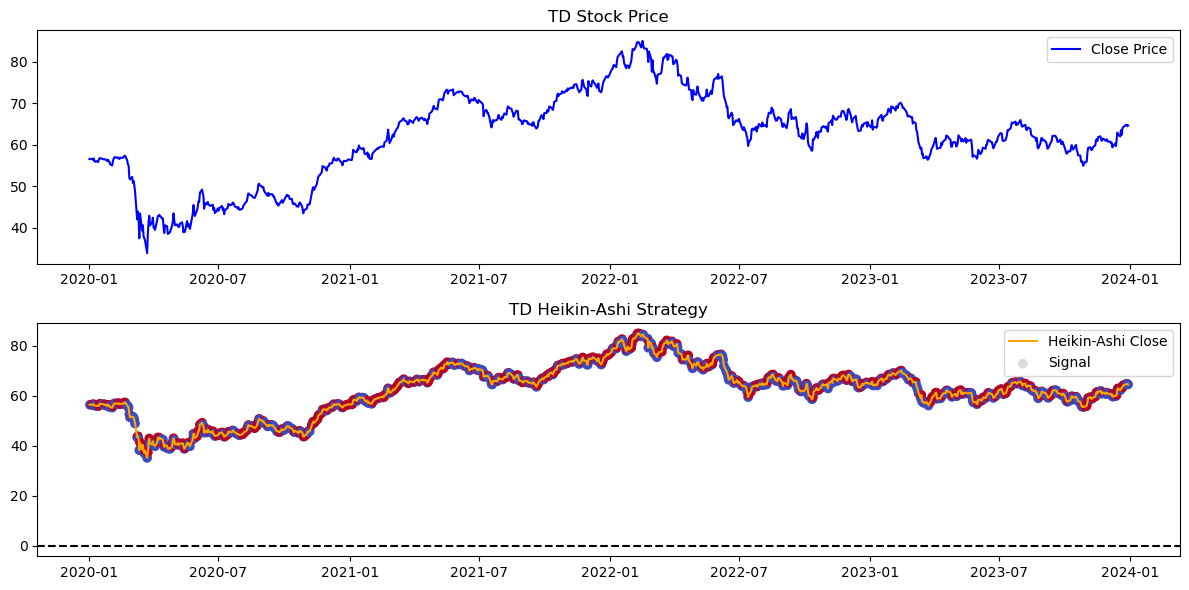

In [23]:

# Heikin-Ashi Strategy Function
def heikin_ashi_strategy(df):
    # Create a copy of the original DataFrame
    ha_df = df.copy()

    # Calculate Heikin-Ashi Close: average of open, high, low, close
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    # Calculate Heikin-Ashi Open: average of previous Heikin-Ashi Open and Close
    ha_df['Open'] = (df['Open'].shift() + df['Close'].shift()) / 2

    # Calculate Heikin-Ashi High: max of the high, open, and close for each row
    ha_df['High'] = df[['Open', 'Close', 'High']].max(axis=1)

    # Calculate Heikin-Ashi Low: min of the low, open, and close for each row
    ha_df['Low'] = df[['Open', 'Close', 'Low']].min(axis=1)

    # Assign Heikin-Ashi columns to the original dataframe
    df['HA_Close'] = ha_df['Close']
    df['HA_Open'] = ha_df['Open']
    
    # Create Buy and Sell signals: 1 (Buy) when HA_Close > HA_Open, -1 (Sell) when HA_Close < HA_Open
    df['Signal'] = 0
    df['Signal'] = np.where(df['HA_Close'] > df['HA_Open'], 1, df['Signal'])   # Buy Signal (HA Close > HA Open)
    df['Signal'] = np.where(df['HA_Close'] < df['HA_Open'], -1, df['Signal'])  # Sell Signal (HA Close < HA Open)

    return df

# Fetch TD Bank (TD) stock data from Yahoo Finance
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Apply Heikin-Ashi strategy to the DataFrame
df = heikin_ashi_strategy(df)

# Plotting the Close price and Heikin-Ashi signals
plt.figure(figsize=(12, 6))

# Plot the Close price
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker} Stock Price')
plt.legend()

# Plot Heikin-Ashi Close and Signals
plt.subplot(2, 1, 2)
plt.plot(df['HA_Close'], label='Heikin-Ashi Close', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.scatter(df.index, df['HA_Close'], c=df['Signal'], cmap='coolwarm', marker='o', label='Signal')
plt.title(f'{ticker} Heikin-Ashi Strategy')
plt.legend()

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
C:\Users\Anand\AppData\Local\Temp\ipykernel_20128\2258028061.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = 'green' if df['HA_Close'][i] > df['HA_Open'][i] else 'red'
C:\Users\Anand\AppData\Local\Temp\ipykernel_20128\2258028061.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([df.index[i-1], df.index[i]], [df['HA_Open'][i], df['HA_Open'][i]], color=color, lw=1)  # Open line
C:\Users\Anand\AppData\Local\Temp\ipykernel_20128\2258028061.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

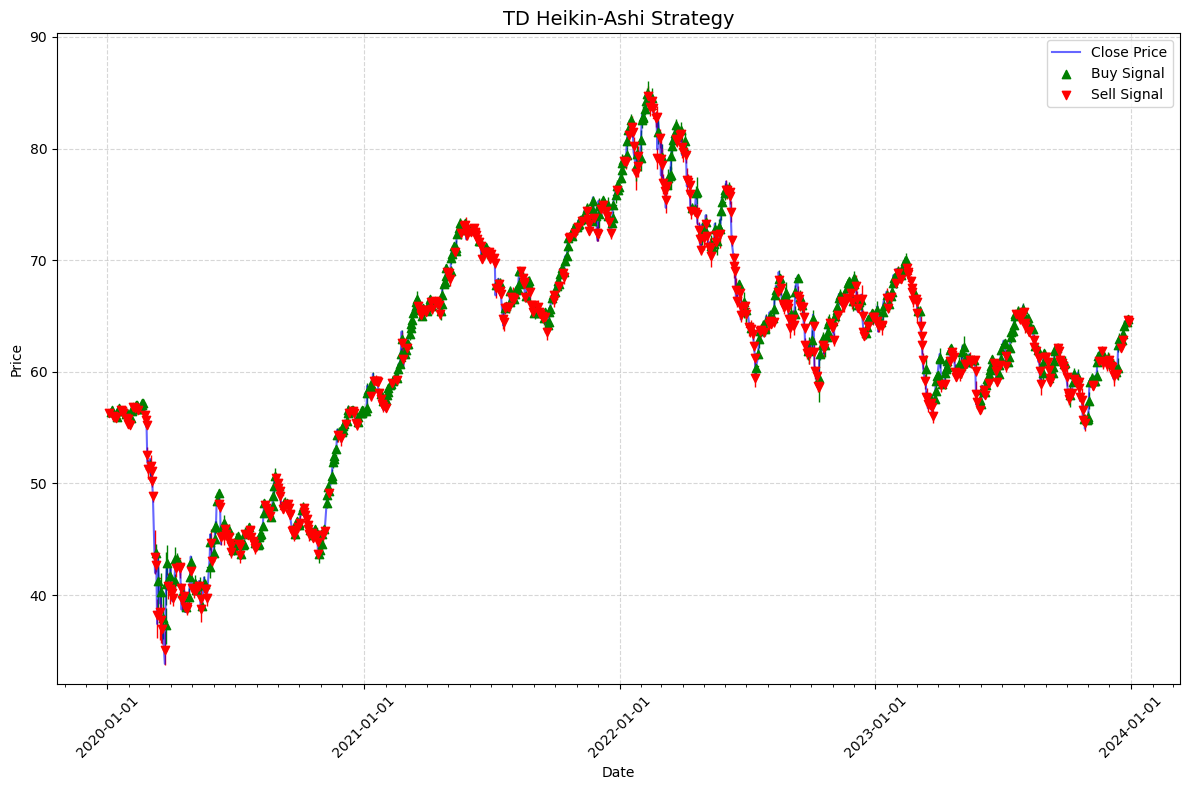

In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Heikin-Ashi Strategy Function
def heikin_ashi_strategy(df):
    # Create a copy of the original DataFrame
    ha_df = df.copy()

    # Calculate Heikin-Ashi Close: average of open, high, low, close
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    # Calculate Heikin-Ashi Open: average of previous Heikin-Ashi Open and Close
    ha_df['Open'] = (df['Open'].shift() + df['Close'].shift()) / 2

    # Calculate Heikin-Ashi High: max of the high, open, and close for each row
    ha_df['High'] = df[['Open', 'Close', 'High']].max(axis=1)

    # Calculate Heikin-Ashi Low: min of the low, open, and close for each row
    ha_df['Low'] = df[['Open', 'Close', 'Low']].min(axis=1)

    # Assign Heikin-Ashi columns to the original dataframe
    df['HA_Close'] = ha_df['Close']
    df['HA_Open'] = ha_df['Open']
    df['HA_High'] = ha_df['High']
    df['HA_Low'] = ha_df['Low']
    
    # Create Buy and Sell signals: 1 (Buy) when HA_Close > HA_Open, -1 (Sell) when HA_Close < HA_Open
    df['Signal'] = 0
    df['Signal'] = np.where(df['HA_Close'] > df['HA_Open'], 1, df['Signal'])   # Buy Signal (HA Close > HA Open)
    df['Signal'] = np.where(df['HA_Close'] < df['HA_Open'], -1, df['Signal'])  # Sell Signal (HA Close < HA Open)

    return df

# Fetch TD Bank (TD) stock data from Yahoo Finance
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Apply Heikin-Ashi strategy to the DataFrame
df = heikin_ashi_strategy(df)

# Plotting the Heikin-Ashi candles and signals
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the Heikin-Ashi Candlesticks using candlestick chart (Green for Buy, Red for Sell)
for i in range(1, len(df)):
    color = 'green' if df['HA_Close'][i] > df['HA_Open'][i] else 'red'
    ax.plot([df.index[i-1], df.index[i]], [df['HA_Open'][i], df['HA_Open'][i]], color=color, lw=1)  # Open line
    ax.plot([df.index[i-1], df.index[i]], [df['HA_Close'][i], df['HA_Close'][i]], color=color, lw=1)  # Close line
    ax.vlines(df.index[i], df['HA_Low'][i], df['HA_High'][i], color=color, lw=1)  # High-low line

# Plot the regular Close price for comparison
ax.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.6)

# Highlight Buy and Sell signals with markers
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]
ax.scatter(buy_signals.index, buy_signals['HA_Close'], marker='^', color='green', label='Buy Signal', alpha=1, zorder=5)
ax.scatter(sell_signals.index, sell_signals['HA_Close'], marker='v', color='red', label='Sell Signal', alpha=1, zorder=5)

# Format the X-axis dates for better readability
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Set y-axis limits to better visualize the price range
ax.set_ylim([df[['Low', 'HA_Low']].min().min() * 0.95, df[['High', 'HA_High']].max().max() * 1.05])

# Labels and title
ax.set_title(f'{ticker} Heikin-Ashi Strategy', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

# Grid and layout
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


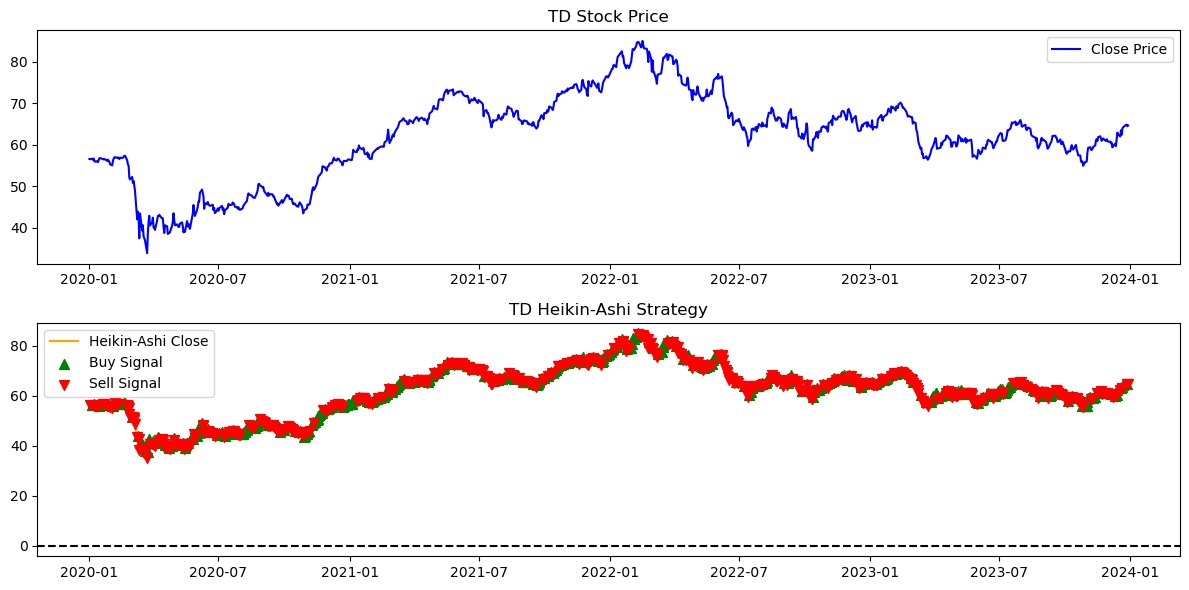

In [27]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Heikin-Ashi Strategy Function
def heikin_ashi_strategy(df):
    # Create a copy of the original DataFrame
    ha_df = df.copy()

    # Calculate Heikin-Ashi Close: average of open, high, low, close
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    # Calculate Heikin-Ashi Open: average of previous Heikin-Ashi Open and Close
    ha_df['Open'] = (df['Open'].shift() + df['Close'].shift()) / 2

    # Calculate Heikin-Ashi High: max of the high, open, and close for each row
    ha_df['High'] = df[['Open', 'Close', 'High']].max(axis=1)

    # Calculate Heikin-Ashi Low: min of the low, open, and close for each row
    ha_df['Low'] = df[['Open', 'Close', 'Low']].min(axis=1)

    # Assign Heikin-Ashi columns to the original dataframe
    df['HA_Close'] = ha_df['Close']
    df['HA_Open'] = ha_df['Open']
    
    # Create Buy and Sell signals: 1 (Buy) when HA_Close > HA_Open, -1 (Sell) when HA_Close < HA_Open
    df['Signal'] = 0
    df['Signal'] = np.where(df['HA_Close'] > df['HA_Open'], 1, df['Signal'])   # Buy Signal (HA Close > HA Open)
    df['Signal'] = np.where(df['HA_Close'] < df['HA_Open'], -1, df['Signal'])  # Sell Signal (HA Close < HA Open)

    return df

# Fetch TD Bank (TD) stock data from Yahoo Finance
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Apply Heikin-Ashi strategy to the DataFrame
df = heikin_ashi_strategy(df)

# Plotting the Close price and Heikin-Ashi signals
plt.figure(figsize=(12, 6))

# Plot the Close price
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker} Stock Price')
plt.legend()

# Plot Heikin-Ashi Close and Signals
plt.subplot(2, 1, 2)
plt.plot(df['HA_Close'], label='Heikin-Ashi Close', color='orange')

# Add Buy and Sell signals with labels
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

# Buy signals (green dots) with smaller markers
plt.scatter(buy_signals.index, buy_signals['HA_Close'], color='green', marker='^', label='Buy Signal', s=50, zorder=5)

# Sell signals (red dots) with smaller markers
plt.scatter(sell_signals.index, sell_signals['HA_Close'], color='red', marker='v', label='Sell Signal', s=50, zorder=5)

# Add a horizontal line at 0 for reference
plt.axhline(0, color='black', linestyle='--')

# Title and legend
plt.title(f'{ticker} Heikin-Ashi Strategy')
plt.legend()

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()


[*********************100%***********************]  1 of 1 completed


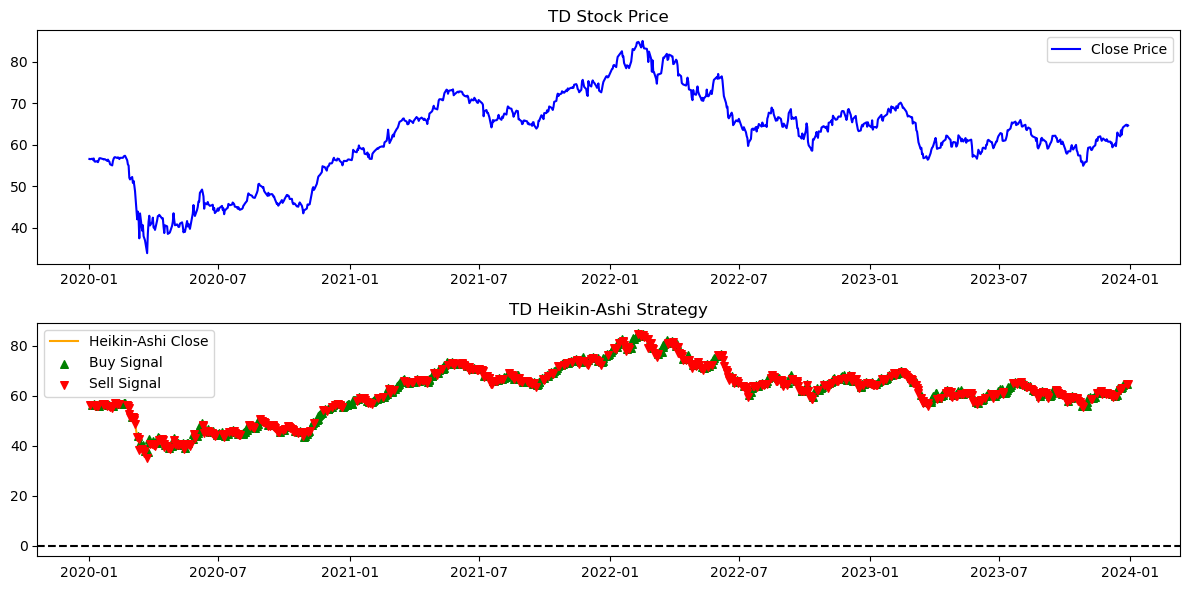

In [281]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Heikin-Ashi Strategy Function
def heikin_ashi_strategy(df):
    # Create a copy of the original DataFrame
    ha_df = df.copy()

    # Calculate Heikin-Ashi Close: average of open, high, low, close
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    # Calculate Heikin-Ashi Open: average of previous Heikin-Ashi Open and Close
    ha_df['Open'] = (df['Open'].shift() + df['Close'].shift()) / 2

    # Calculate Heikin-Ashi High: max of the high, open, and close for each row
    ha_df['High'] = df[['Open', 'Close', 'High']].max(axis=1)

    # Calculate Heikin-Ashi Low: min of the low, open, and close for each row
    ha_df['Low'] = df[['Open', 'Close', 'Low']].min(axis=1)

    # Assign Heikin-Ashi columns to the original dataframe
    df['HA_Close'] = ha_df['Close']
    df['HA_Open'] = ha_df['Open']
    
    # Create Buy and Sell signals: 1 (Buy) when HA_Close > HA_Open, -1 (Sell) when HA_Close < HA_Open
    df['Signal'] = 0
    df['Signal'] = np.where(df['HA_Close'] > df['HA_Open'], 1, df['Signal'])   # Buy Signal (HA Close > HA Open)
    df['Signal'] = np.where(df['HA_Close'] < df['HA_Open'], -1, df['Signal'])  # Sell Signal (HA Close < HA Open)

    return df

# Fetch TD Bank (TD) stock data from Yahoo Finance
ticker = 'TD'
start_date = '2020-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Apply Heikin-Ashi strategy to the DataFrame
df = heikin_ashi_strategy(df)

# Plotting the Close price and Heikin-Ashi signals
plt.figure(figsize=(12, 6))

# Plot the Close price
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker} Stock Price')
plt.legend()

# Plot Heikin-Ashi Close and Signals
plt.subplot(2, 1, 2)
plt.plot(df['HA_Close'], label='Heikin-Ashi Close', color='orange')

# Add Buy and Sell signals with labels
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

# Buy signals (green dots) with smaller markers
plt.scatter(buy_signals.index, buy_signals['HA_Close'], color='green', marker='^', label='Buy Signal', s=30, zorder=5)

# Sell signals (red dots) with smaller markers
plt.scatter(sell_signals.index, sell_signals['HA_Close'], color='red', marker='v', label='Sell Signal', s=30, zorder=5)

# Add a horizontal line at 0 for reference
plt.axhline(0, color='black', linestyle='--')

# Title and legend
plt.title(f'{ticker} Heikin-Ashi Strategy')
plt.legend()

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()


### <b> 7. </b> Renko Chart Strategy [Neel]

In [73]:
def renko_strategy(df, brick_size=2):
    renko_df = df.copy()
    renko_df['Brick'] = (renko_df['Close'] // brick_size) * brick_size
    
    renko_df['Uptrend'] = renko_df['Brick'] > renko_df['Brick'].shift()
    renko_df['Downtrend'] = renko_df['Brick'] < renko_df['Brick'].shift()
    
    df['Signal'] = 0
    df['Signal'] = np.where(renko_df['Uptrend'], 1, df['Signal'])
    df['Signal'] = np.where(renko_df['Downtrend'], -1, df['Signal'])
    
    return df

### <b> 8. </b> Mean Reversion with Bollinger Bands and RSI Strategy [Neel]

In [79]:
def bollinger_bands_rsi_strategy(df, bb_period=20, rsi_period=14):
    df['MA20'] = df['Close'].rolling(window=bb_period).mean()
    df['BB_Upper'] = df['MA20'] + 2 * df['Close'].rolling(window=bb_period).std()
    df['BB_Lower'] = df['MA20'] - 2 * df['Close'].rolling(window=bb_period).std()
    
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['Signal'] = 0
    df['Signal'] = np.where((df['Close'] < df['BB_Lower']) & (df['RSI'] < 30), 1, df['Signal'])
    df['Signal'] = np.where((df['Close'] > df['BB_Upper']) & (df['RSI'] > 70), -1, df['Signal'])
    
    return df

### <b> 9. </b> Dual Moving Average Strategy [Neel]

In [83]:
def dual_moving_average_strategy(df, short_window=50, long_window=200):
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    
    df['Signal'] = 0
    df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, 0)
    df['Signal'] = np.where(df['Short_MA'] < df['Long_MA'], -1, df['Signal'])
    
    return df

## <span style="color: purple;">4️⃣ <b><u>Backtesting</u></b></span>

In [24]:
# Function to backtest a given trading strategy
def backtest_strategy(strategy, df):
    bt = Backtest(df, strategy, cash=10000, commission=.002)
    stats = bt.run()
    return stats

## <span style="color: brown;">5️⃣ <u><b>Comparing with TD Mutual Fund</b></u></span>

In [40]:
# Function to compare trading strategy with a mutual fund
def compare_with_mutual_fund(strategy_results, mutual_fund_data):
    combined_data = pd.concat([strategy_results['_equity_curve']['Equity'], mutual_fund_data], axis=1)
    combined_data.columns = ['Strategy Equity', 'Mutual Fund']
    combined_data.plot(figsize=(12, 6), title='Strategy vs Mutual Fund Comparison')
    plt.ylabel('Equity')
    plt.show()

# Function to load mutual fund data
def get_mutual_fund_data(ticker, start_date, end_date, interval='1d'):
    return get_stock_data(ticker, start_date, end_date, interval)['Close']

# Example usage with a placeholder trading strategy
def trading_strategy(df):
    # Placeholder strategy - Buy and hold
    df['Signal'] = 1
    return df